# Exploratory Data AnalysisIn this notebook, I conduct a brief exploratory data analysis of the Airbus ship detection image dataset. The goal is to prepare the dataset for model training and select the most suitable methods for the segmentation task.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Import dataset containing image names and corresponding length-encoded masks
df = pd.read_csv(r"airbus/train_ship_segmentations_v2.csv")

In [3]:
# Display the CSV file
df.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [4]:
# Create a column indicating the count of ships per image
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform("count")
df.loc[df['EncodedPixels'].isnull().values,'ship_count'] = 0

In [5]:
def count_ship_pixels(mask_data):
    """
    This function takes in mask data representing segmented image information 
    and decodes it to count the number of pixels belonging to a specific class.
    
    Args:
    - mask_data (str): A string representing mask data.
    
    Returns:
    - lengths (list): A list containing the lengths of consecutive pixels belonging to a 
    specific class.
    """
    if isinstance(mask_data, float):
        return [0]
    s = mask_data.split()
    lengths = [int(x) for x in s[1:][::2]]
    return lengths

In [24]:
# Create a dataset comprising only images with the 'ship' class
df_ships = df[df["ship_count"] > 0]
percent_with_ships = (len(df_ships.groupby("ImageId").count()) / len(df.groupby("ImageId").count()) * 100)
print(f"Percent of images with ships: {percent_with_ships:.4f}%")

Percent of images with ships: 22.0595%


Calculate the ratio of 'Ship' pixels to background pixels for all images in the dataset and the ratio for images containing ships only.

In [7]:
# Calculate the total number of pixels belonging to the 'ship' class across the entire dataset
class_pixels = 0
for mask_data in df["EncodedPixels"]:
    current_sum = sum(count_ship_pixels(mask_data))
    class_pixels += current_sum


class_pixels_ships = 0
for mask_data in df_ships["EncodedPixels"]:
    current_sum = sum(count_ship_pixels(mask_data))
    class_pixels_ships += current_sum

# Check the pixel ratio
class_to_background_ratio = class_pixels / (len(df.groupby("ImageId").count()) * 768**2) * 100
class_to_background_ratio_ships = class_pixels_ships / (len(df_ships.groupby("ImageId").count()) * 768**2) * 100
print(f"Ship pixels to background pixels ratio for all images in the dataset:  {class_to_background_ratio:.4f} %")
print(f"Ship pixels to background pixels ratio for images containing ships only: {class_to_background_ratio_ships:.4f} %")

Ship pixels to background pixels ratio for all images in the dataset:  0.1128 %
Ship pixels to background pixels ratio for images containing ships only: 0.5103 %


Due to the extreme imbalance in the dataset, training the segmentation model only on images with ships might be beneficial. Handling images without ships can be done with a classification model.

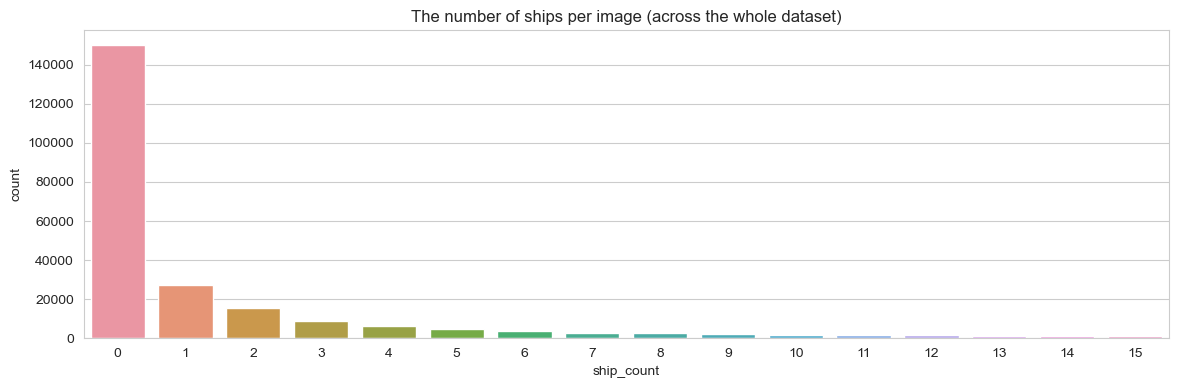

In [8]:
# Visualize the number of ships per image throughout the entire dataset
plt.figure(figsize=(14,4))
sns.set_style(style="whitegrid")
sns.countplot(data=df, x="ship_count")
plt.title("The number of ships per image (across the whole dataset)");

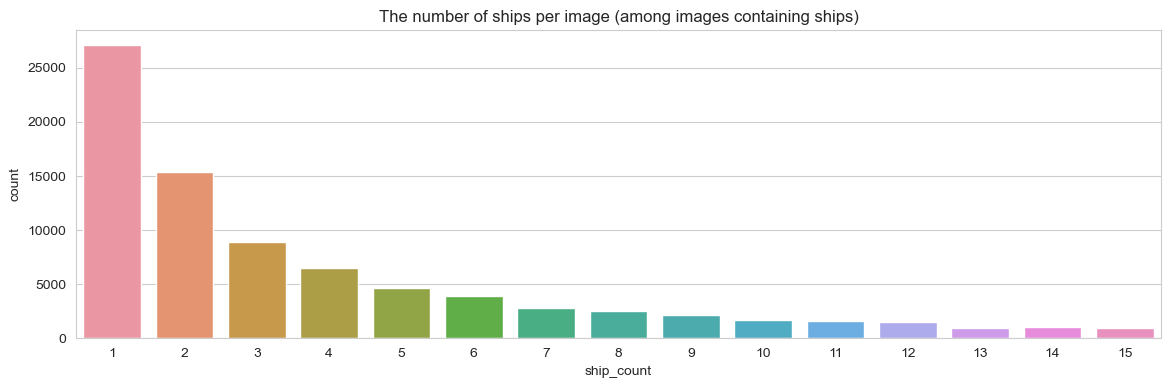

In [9]:
# Visualize the number of ships per image among images containing ships in the dataset
plt.figure(figsize=(14,4))
sns.set_style(style="whitegrid")
sns.countplot(data=df_ships, x="ship_count")
plt.title("The number of ships per image (among images containing ships)");

In [10]:
def create_mask(mask_data, shape=(768, 768)):
    """
    Creates a mask based on the provided mask data, representing segmented image information.

    Args:
    - mask_data (str): A string representing mask data.
    - shape (tuple, optional): The shape of the mask to be created. Defaults to (768, 768).

    Returns:
    - img (numpy.ndarray): A mask represented as a NumPy array with values indicating pixel 
    presence (1) or absence (0) for the specified classes within the given shape.
    """
    if isinstance(mask_data, float):
        return np.zeros(shape, dtype=np.uint8)
        
    s = mask_data.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape).T

In [11]:
# Define a colormap (from transparent to yellow) for masks
transparent_yellow = LinearSegmentedColormap.from_list("transparent_yellow", [(1, 1, 0, 0), (1, 1, 0, 1)], N=256)

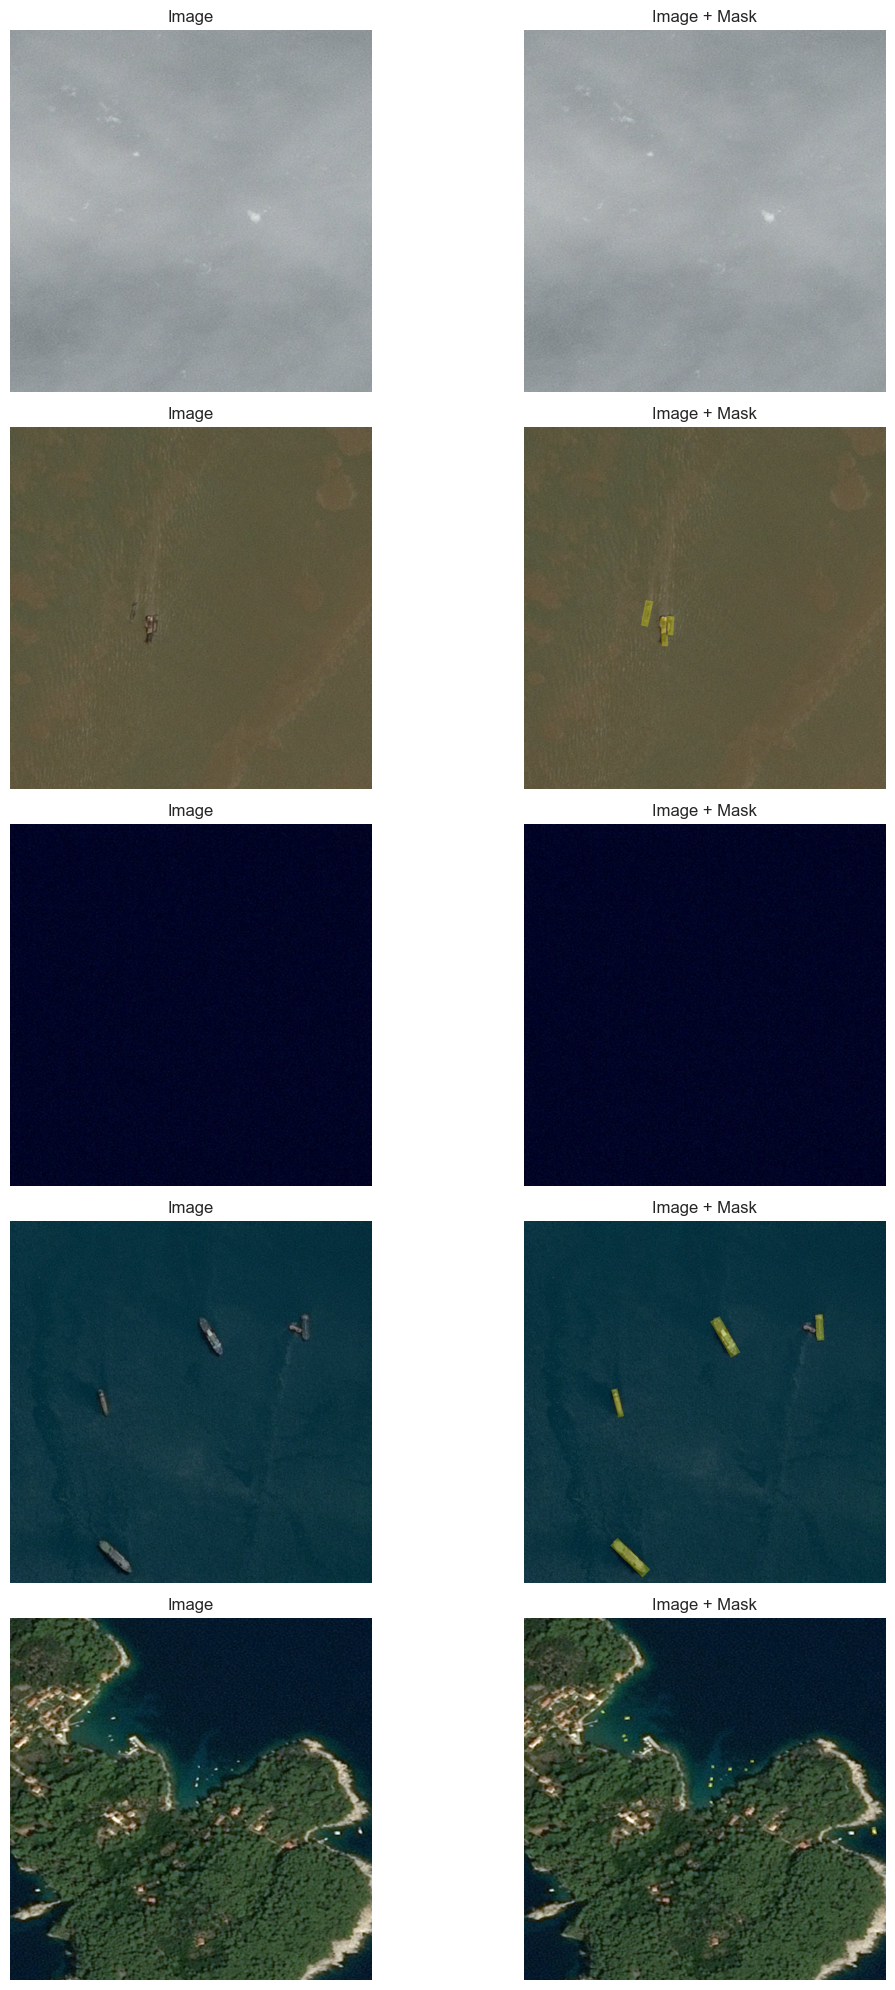

In [12]:
# Visualize random images and their corresponding merged masks
random.seed(42)
images = df.groupby("ImageId").count().reset_index()["ImageId"].to_list()

selected_image = random.sample(images, 5)
image_paths = [os.path.join(r"airbus/train_v2", img) for img in selected_image]

fig, axarr = plt.subplots(5, 2, figsize=(12, 20))

for idx, img_path in enumerate(image_paths):
    img_name = os.path.basename(img_path)
    img = plt.imread(img_path)
    img_masks = df.loc[df['ImageId'] == img_name, 'EncodedPixels'].tolist()
    
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += create_mask(mask)

    axarr[idx, 0].imshow(img)
    axarr[idx, 0].set_title('Image')
    axarr[idx, 0].axis('off')
    
    axarr[idx, 1].imshow(img)
    axarr[idx, 1].imshow(all_masks, alpha=0.3, cmap=transparent_yellow)
    axarr[idx, 1].set_title('Image + Mask')
    axarr[idx, 1].axis('off')

plt.tight_layout()

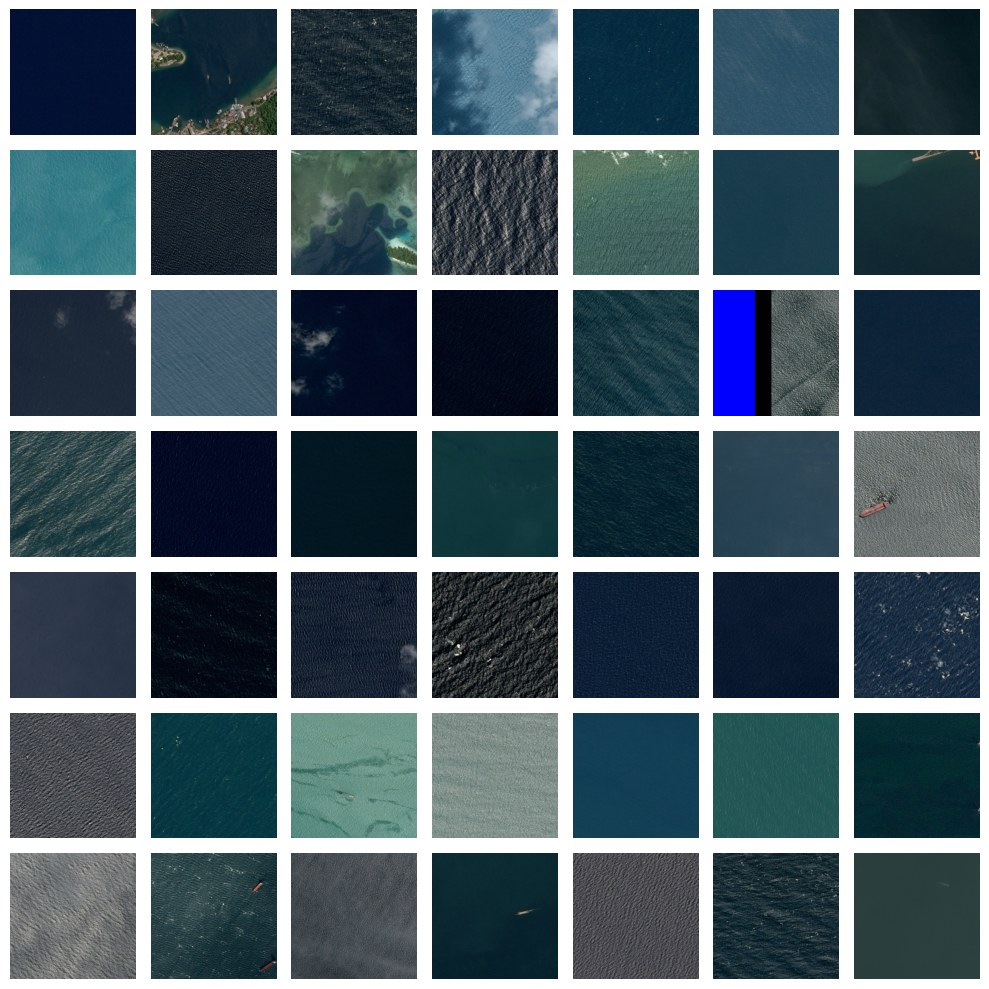

In [13]:
# Visualize random images
random.seed(8)
grid_size = 7

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        rand_img_path = os.path.join(r"airbus/train_v2", random.choice(images))
        img = plt.imread(rand_img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

plt.tight_layout()

Some images appear corrupted, containing regions of pure blue and black pixels. To detect these images, we can write the following function:

In [14]:
def find_corrupted_images(images, root=r"airbus/train_v2"):
    """
    Searches for corrupted images within a given list of image filenames.

    Args:
    - images (list): A list containing filenames of images to be checked for corruption.
    - root (str, optional): The root directory where the images are located. Defaults to "airbus/train_v2".

    Returns:
    - corrupted_images (list): A list of images identified as potentially corrupted based on a predefined grid analysis.

    Note:
    - If an image encounters an error during processing (e.g., fails to load or process), it is caught as an exception, 
      and the image is also added to the list of corrupted images.
    """
    corrupted_images = []
    total_images = len(images)
    grid_size = 7
    reference = [0, 0, 254]
    
    for idx, img_name in enumerate(images):
        try:
            img_path = os.path.join(root, img_name)
            img = plt.imread(img_path)
            height, width, _ = img.shape
            x_coords = np.linspace(0, width, grid_size + 1, dtype=int)
            y_coords = np.linspace(0, height, grid_size + 1, dtype=int)
            X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
            grid_pixels = img[Y[:-1, :-1], X[:-1, :-1]]
            mask = np.all(grid_pixels == reference, axis=-1)
            if np.any(mask):
                corrupted_images.append(img_name)
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            corrupted_images.append(img_name)
            
        print(f"Progress: {idx + 1}/{total_images}", end='\r')
    
    return corrupted_images

In [15]:
# Create a list of corrupted images
corrupted_images = find_corrupted_images(images)

Error processing 6384c3e78.jpg: image file is truncated (55 bytes not processed)


In [16]:
print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 457


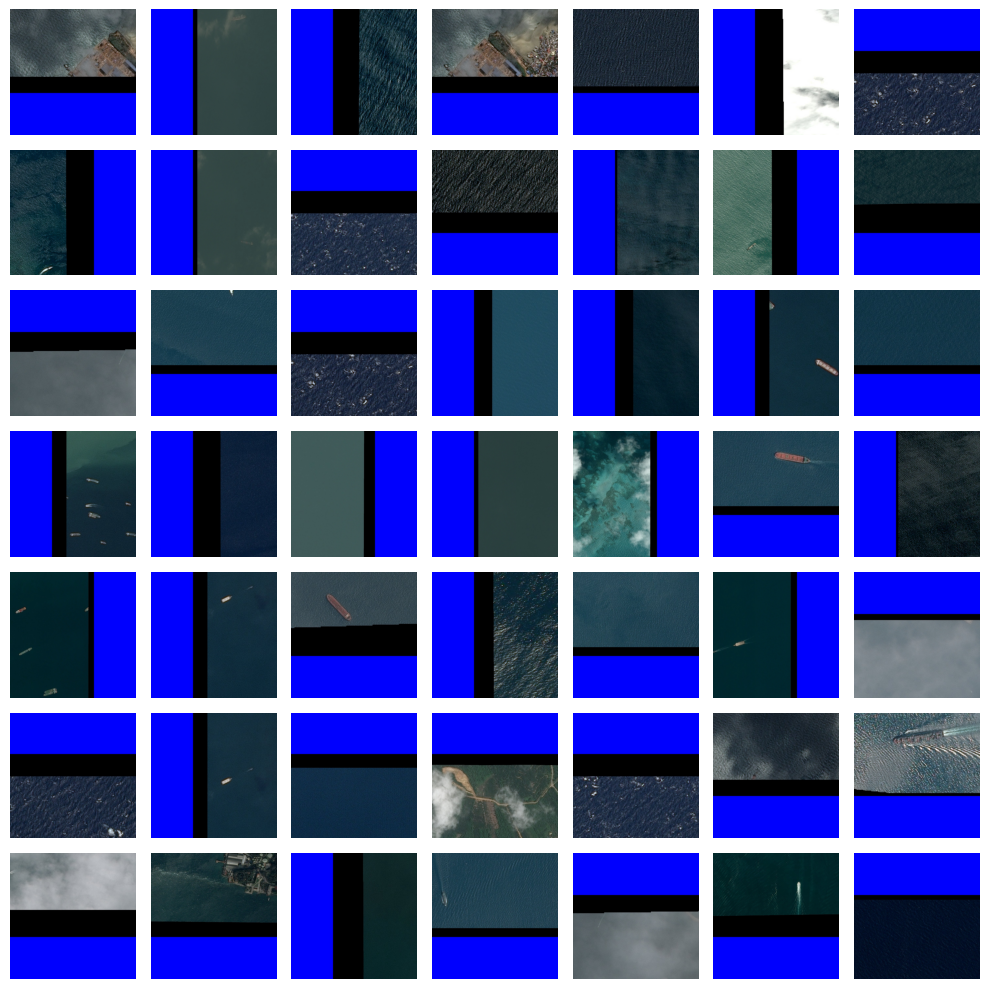

In [17]:
# Visualize random corrupted images (Note: Removing the random seed might result in an error in this cell)
random.seed(15)
grid_size = 7

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        rand_img_path = os.path.join(r"airbus/train_v2", random.choice(corrupted_images))
        img = plt.imread(rand_img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
plt.tight_layout()

In [18]:
# Remove corrupted images
df = df[~df["ImageId"].isin(corrupted_images)]

In [19]:
# Add labels
df["ship_present"] = df["ship_count"].apply(lambda x: 0 if x == 0 else 1)

In [20]:
# Display the prepared CSV file with ship segmentation information
df.head(10)

ImageId                                      EncodedPixels  \
0  00003e153.jpg                                                NaN   
1  0001124c7.jpg                                                NaN   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...   
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...   
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...   
8  0001b1832.jpg                                                NaN   
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...   

   ship_count  ship_present  
0           0             0  
1           0             0  
2           1             1  
3           5             1  
4           5             1  
5           5             1  
6           5             1  
7           5             1  
8           0             0  
9           9             1

In [21]:
# Save the prepared CSV file with ship segmentation information
df.to_csv("train_ship_segmentations_prepared.csv", index=False)